In [1]:
import utils.hgg_utils as hu
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm 
from model import unet
from utils.dice import dice_loss as dice
from utils.dice import dice_coef as dice_coef
from sklearn.utils import shuffle
from IPython import display
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import time
import pickle

In [2]:
def get_hist(my_file_path):
    
    my_file = "ds_{}_run_{}_histories.pkl".format(ds_num, run_num)
    with open(my_file, "rb") as file_pi:
        hist = pickle.load(file_pi)
    
    return hist

In [3]:
def grab_mean_over_chunks(history, key):
    
    # Data clean -- remove nans
    for epoch in range(len(history)):
                
        #epoch_mean = np.mean(   np.where( (np.array( history[epoch] ))).isnan   )
        
        #print("epoch mean:", epoch_mean)
        #print(type(epoch_mean))
    
        
        for chunk in range(len(history[epoch])):
            if np.isnan(history[epoch][chunk][key]) :
        
                #nans replaced with average of previous and next datapoints
                #print()

                #print("MEAN")
                #print(np.mean( history[epoch][chunk-1][key] +  history[epoch][chunk+1][key] ))
                #print()
                
                #print("*"*40)
                #print( history[epoch][chunk][key] )
                #pass
                if history[epoch][chunk-1][key][0] > 0.9:
                    history[epoch][chunk][key][0] = 1
                elif history[epoch][chunk-1][key][0] < 0.1:
                    history[epoch][chunk][key][0] = 0
                    
                elif chunk==0 and  np.isnan(history[epoch][chunk][key][0]):
                    
                    if key=="loss":
                        history[epoch][chunk][key][0] = 1
                        
                    elif key=="val_loss":
                        history[epoch][chunk][key][0] = 1
                        
                    elif key=="dice_coef":
                        history[epoch][chunk][key][0] = 0
                        
                    elif key=="val_dice_coef":
                        history[epoch][chunk][key][0] = 0

                    
                else:
                    #print(history[epoch][chunk-1][key][0])
                    #print(history[epoch])

                    
                    
                    raise ValueError("NaN is not preceded by a value near 0 or 1")
                
                    
                #history[epoch][chunk][key] = np.mean( history[epoch][chunk-1][key] +  history[epoch][chunk+1][key] )
    
    
    
    avg = []
    
    for epoch in range(len(history)):
        avg.append( np.mean([x[key] for x in history[epoch]]) )
    
    #print(len(avg))
    
    return avg

In [4]:
def get_mean_and_std_over_runs(my_list, metric):

#     print("metric:", metric)
#     for i in my_list:
#         print(i)
#         print()
#     print()
#     print()
    #types = set()
    #for i in my_list:
        
    #    types.add(i.dtype)
    
    my_mean = np.mean(my_list, axis=0)
    my_std = np.std(my_list, axis=0)
    
    #print("my_mean length", len(my_mean))
    #print("my_std length:", len(my_std))
    
    return my_mean, my_std


In [14]:
def plot_fig(ds, metric, data_mean, data_std, val_mean, val_std):

    plt.ylim(0,1)
    plt.xlim(0, 20)
    #print("data mean length:", len(data_mean))
    #print("data std length:", len(data_std))
    #print("val mean length:", len(val_mean))
    #rint("val std length:", len(val_std))
    
    
    # Plot 
    plt.plot(data_mean)
    plt.fill_between(range(len(data_mean)), 
                     data_mean + data_std,
                     data_mean - data_std,
                     alpha=0.2
                    )

    plt.plot(val_mean)
    plt.fill_between(range(len(val_mean)), 
                     val_mean + val_std,
                     val_mean - val_std,
                     alpha=0.2
                    )

    plt.title('DS {} Average {} Across Runs'.format(ds, metric))
    plt.ylabel('Average {}'.format(metric))
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()
    
    #plt.savefig("ds_{}_{}_plot".format(ds, metric))

    
    plt.close()

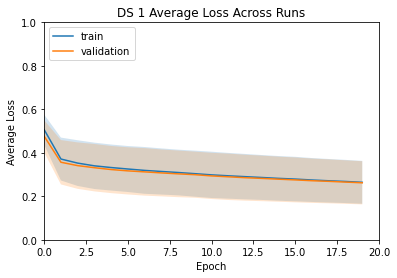

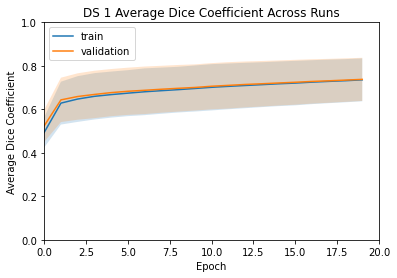

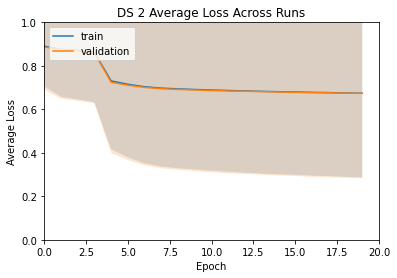

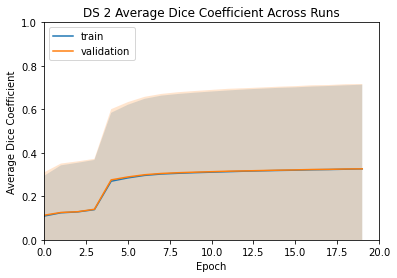

d:\anaconda\envs\4850\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
d:\anaconda\envs\4850\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


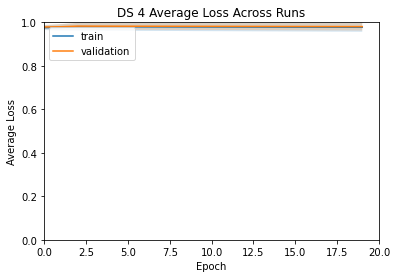

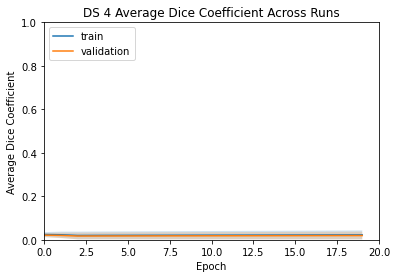

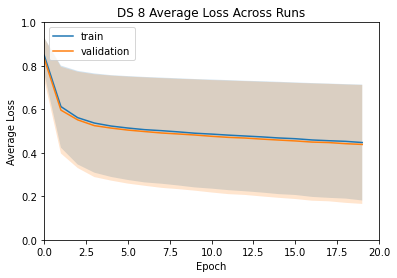

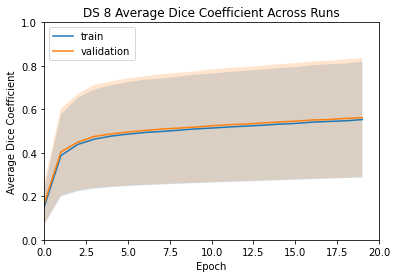

In [15]:
ds_vals = [1, 2, 4, 8]

for i, ds_num in enumerate(ds_vals):

    all_avg_epoch_losses = []
    all_avg_epoch_val_losses = []
    all_avg_epoch_dice_coef = []
    all_avg_epoch_val_dice_coef = []
    
    for run_num in range(5): 

        ## Grab data for plotting

        ## Open file
        hist = get_hist("ds_{}_run_{}_histories.pkl".format(ds_num, run_num))

        #print(hist)
        
        
        
        ## Avg losses 
        avg_epoch_losses = grab_mean_over_chunks(hist, "loss")

        ## Avg validation losses
        avg_epoch_val_losses = grab_mean_over_chunks(hist, "val_loss")

        ## Avg epoch dice coefficient
        avg_epoch_dice_coef = grab_mean_over_chunks(hist, "dice_coef")

        ## Avg epoch validation dice coefficient   
        avg_epoch_val_dice_coef = grab_mean_over_chunks(hist, "val_dice_coef")

        
        all_avg_epoch_losses.append(avg_epoch_losses)
        all_avg_epoch_val_losses.append(avg_epoch_val_losses)
        all_avg_epoch_dice_coef.append(avg_epoch_dice_coef)
        all_avg_epoch_val_dice_coef.append(avg_epoch_val_dice_coef)


    
        
    # Mean & STD over runs: epoch loss
    mean_epoch_losses_for_runs, std_epoch_losses_for_runs = get_mean_and_std_over_runs(all_avg_epoch_losses, "loss")
        
    # Mean & STD over runs: epoch validation loss
    mean_epoch_val_losses_for_runs, std_epoch_val_losses_for_runs = get_mean_and_std_over_runs(all_avg_epoch_val_losses, "val_loss")
    
    #print(len(mean_epoch_losses_for_runs))
    #print(len(std_epoch_losses_for_runs))
    #print(len(mean_epoch_val_losses_for_runs))
    #print(len(std_epoch_val_losses_for_runs))

    
    # plot losses
    plot_fig(ds=ds_num, 
             metric="Loss", 
             data_mean=mean_epoch_losses_for_runs, 
             data_std=std_epoch_losses_for_runs, 
             val_mean=mean_epoch_val_losses_for_runs, 
             val_std=std_epoch_val_losses_for_runs
    )

    
    # Mean & STD over runs: dice coef
    mean_epoch_dice_coef_for_runs, std_epoch_dice_coef_for_runs = get_mean_and_std_over_runs(all_avg_epoch_dice_coef, "dice_coef")
        
    # Mean & STD over runs:  validation dice coef
    mean_epoch_val_dice_coef_for_runs, std_epoch_val_dice_coef_for_runs = get_mean_and_std_over_runs(all_avg_epoch_val_dice_coef, "val_dice_coef")

    #print(len(mean_epoch_dice_coef_for_runs))
    #print(len(std_epoch_dice_coef_for_runs))
    #print(len(mean_epoch_val_dice_coef_for_runs))
    #print(len(std_epoch_val_dice_coef_for_runs))
    
    # plot dice
    plot_fig(ds=ds_num, 
             metric="Dice Coefficient", 
             data_mean=mean_epoch_dice_coef_for_runs, 
             data_std=std_epoch_dice_coef_for_runs, 
             val_mean=mean_epoch_val_dice_coef_for_runs, 
             val_std=std_epoch_val_dice_coef_for_runs
    )
    
    

    